<a href="https://colab.research.google.com/github/FlexliTushar/Flow-Charts/blob/main/TMSFlowControlFeature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TMS - Flow Control Feature

## Strategy

In [ ]:
//Messaging_server will send bot-position of Bx as
// X -> S6 -> D7 when passing station X
GET new bot-positions;
// To resolve the occupied and allocated station requests of Bx for X and S6.
2 iterations of TMS;
//1. It will try to make request for D7 in 3rd iteration but that will be rejected and added into rejectedRequests in StationAllocationPlanService
// 2. In 4th iteration it will create request for original assigned station
CREATE station request for Bx of
type 'Assign' for D7;
if((Bx, D7, Assign) EXIST in
rejectedRequests)
{
  //1. TRIGGER - Assigned Station was not available
  //2. Allocated station here S6 which is a flow control station
  if(Allocated Station is a Flow
  Control Station?)
  {
    // The bot By which is occupying the station D7 i.e. station for which assigned request is rejected
    // (Refer checkBot motor for 'By' flow chart)
    if(Motor of ahead bot 'By' = True)
    {
      // Means bot is already moving ahead and will not create congestion
      Continue with existing logic;
    }
    else
    {
      //Refer Redirection Flow Chart
      REDIRECT Bx;
      // After redirection, the valid next station comes out to be S5
      CREATE new station request of Bx
      for S5 of type 'Assign';
      // _redirectedRequests will keep the track of all the redirected requests that have occured in this iteration in BotStationRequestService
      ADD (Bx, S5, Assign) in
      _redirectedRequests;
      Continue with existing logic;
    }
  }
  
  // if not a flow control station then cannot do anything
  else
  {
    Continue with existing logic;
  }
}
// assign station request was not rejected/coming first time
else
{
  Continue with existing logic;
}
// redirectedRequests from BotStationRequests are used to update the Rule = R and RedirectedStationId = S5 for Bx

UPDATE unresolvedBotPositions using
redirectedRequests;
// 1. It will try to update for both original assign request for D7 and redirected assign request for S5
// 2. If original is completed then redirected request is added into _nonRequiredRequests
// 3. For every request if it exists in _nonRequiredRequests then break (this will ensure that if original request is fulfilled then no need to process redirection request)
// 4. If request not completed then add it to _rejectedrequests
UPDATE the station allocation plan;
UPDATE the bot_motor;
// If it does gets D7
if(Assigned Station is given to Bx?)
{
  Continue with existing logic;
}
// If redirected assign request is resolved for S5
else
{
  if(Rule = R? and BotId in Redirected
  Station Plan is same as as Bx)
  {
    WRITE motor command with
    Code 'R' and assigned station id
    as redirected station id;
    Continue with existing logic;
  }
  else
  {
    Continue with existing logic;
  }
}

// simulation bot code
if(Bot gets Rule R?)
{
  REPLAN AND RECALCULATE path
  according to new bot_motor;
  Continue with existing logic;
}
else
{
  Continue with existing logic;
}

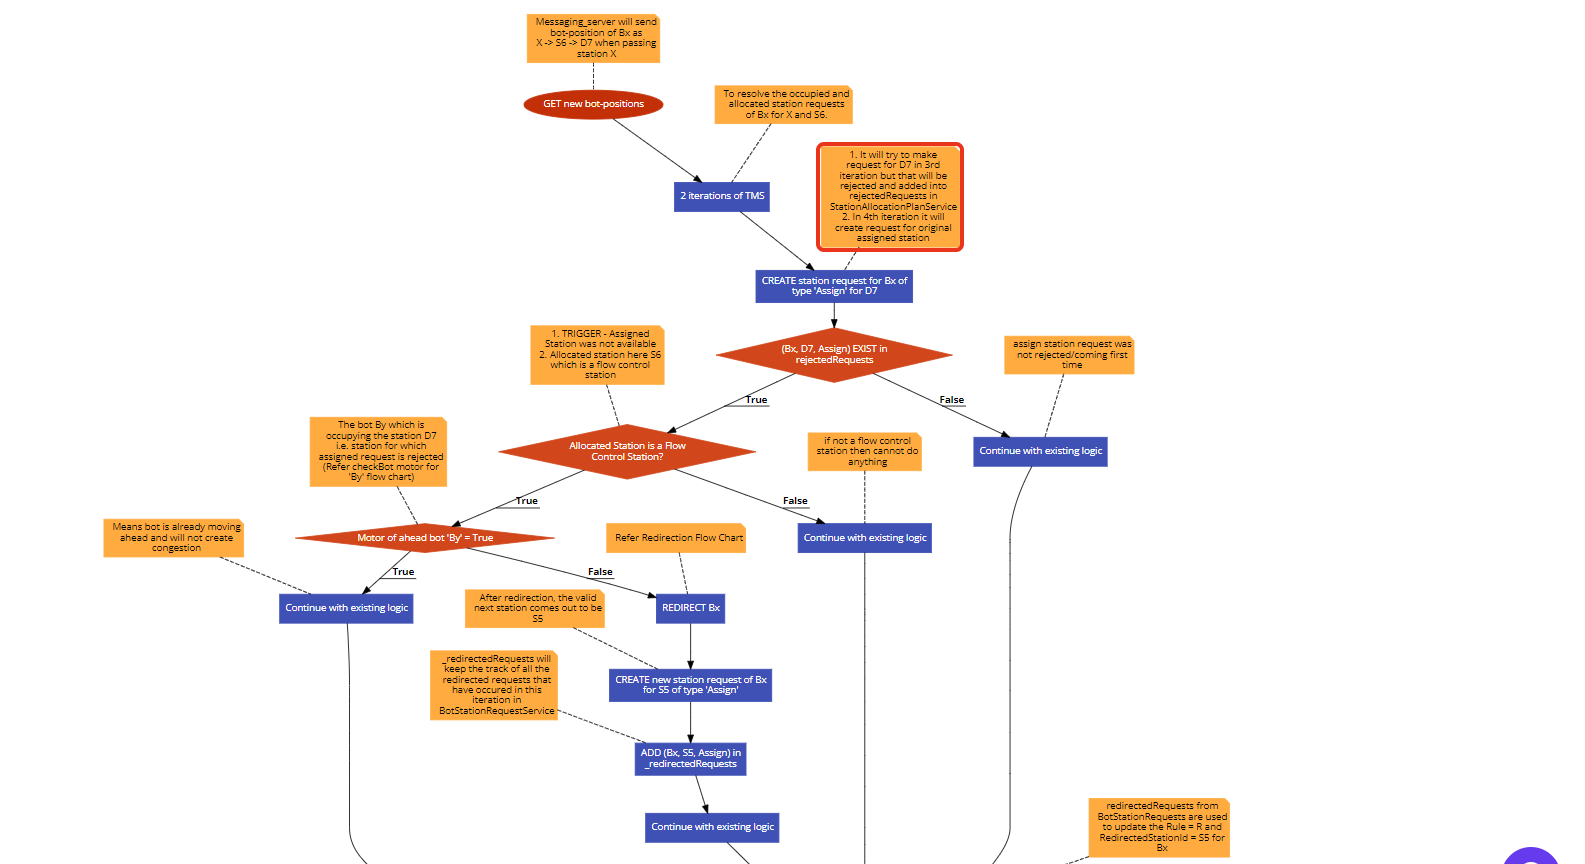

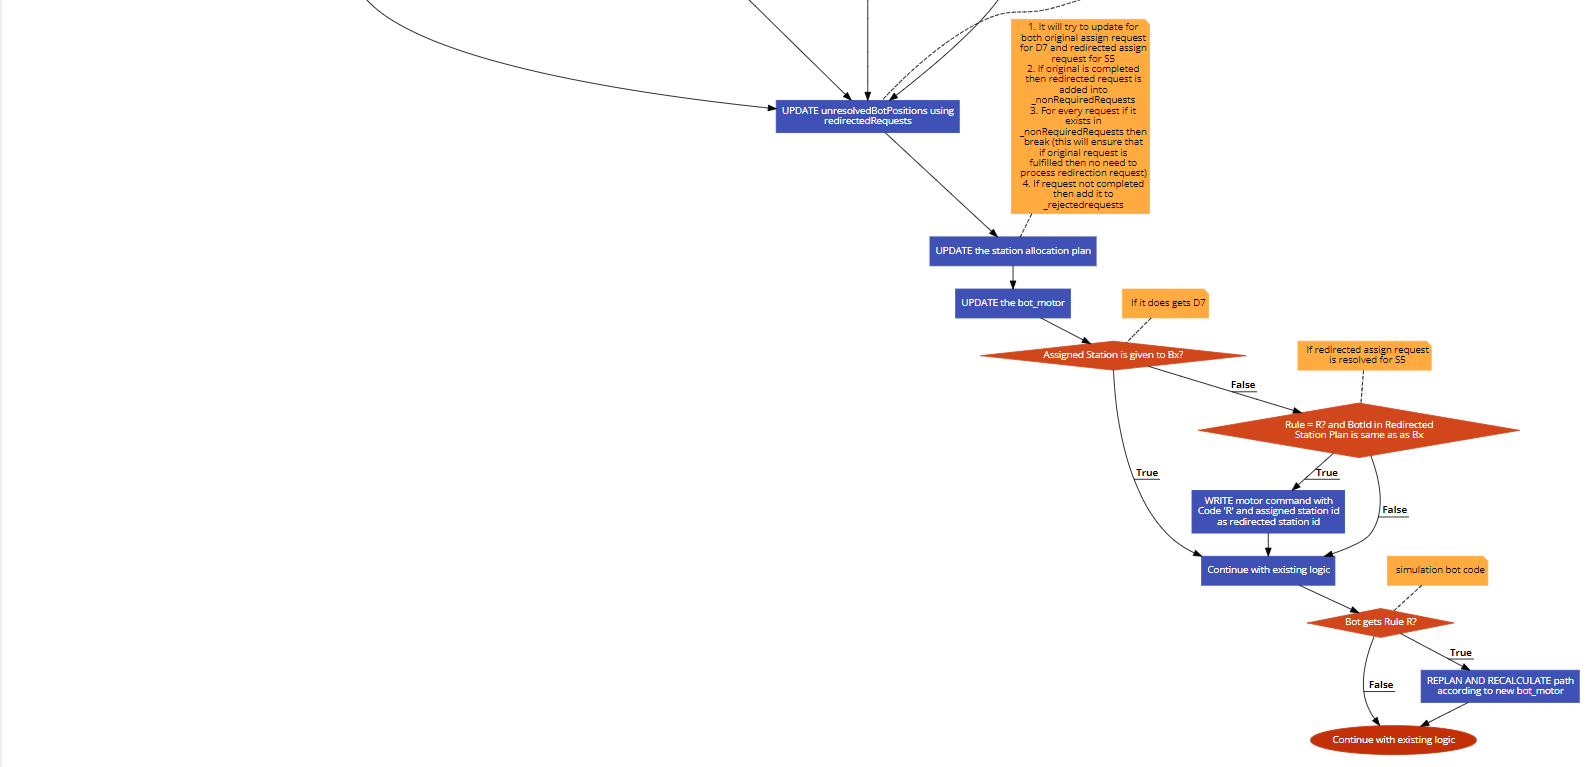

In [ ]:
https://drive.google.com/file/d/14p4jKLDoot7XHo-rqrUnkS3JhMdtPRYi/view?usp=share_link

## Redirection Logic

In [ ]:
// 1. This will happen when we found out that allocated station is a flow control station
//2. From station-to-station-virtual-path.json file
//Path: (S5, V12, V1, D7)
GET station to station virtual
path from allocated to assigned
stations;
//It will come out to be V12 and remember V1
FIND the virtual junction just after
allocated station;
//station-json-model.json file
//forward Nodes = ["V1", "V13"] for station : "V12"
// It will come out to be V13
GET the forward Node of V12 which
is not V1;
//Path: (V13, S5....., D7)
GET station to station virtual
path from V13 to D7;
//Path: (S5,...., D7)
REMOVE virtual nodes from path;
// First element of path
CREATE new assign station request for S5;

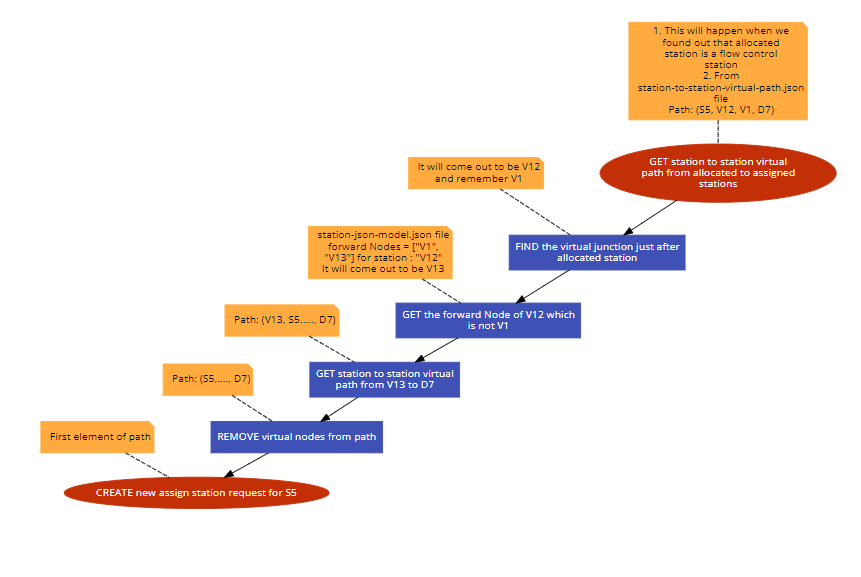

## Check the Motor value of ahead bot (bot which is currently occupying the assigned station of requesting bot)

In [ ]:
// In case of redirection, check whether the bot which is occupying the assigned station is moving or halted
// If it is halted, only then we will proceed for redirection
CHECK motor of ahead bot;
// allBotPositions refer to the unresolvedBotPositions
From allBotPositions check for the botPosition
whose OccupiedStationId == AssignedStationId
of the requesting bot;
// It may come NULL if either bot don't exist at the station or is already resolved (being resolved gives a guarantee that bot got all it's stations and it must be moving)
if(botPosition NOT NULL)
{
  if(botPosition.Motor != True)
  {
    return Return False;
  }
}
return Return True;

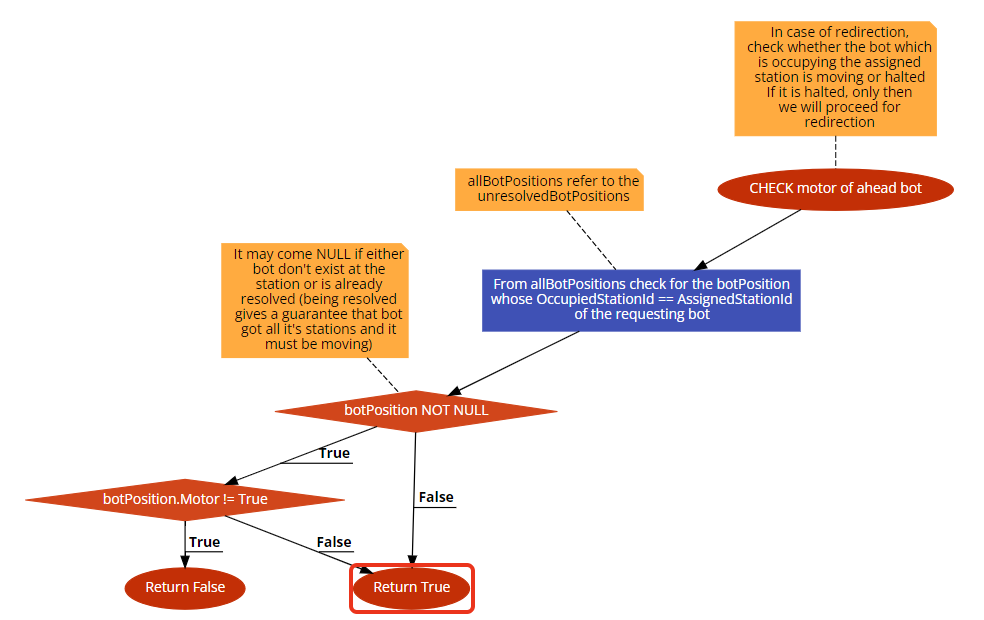

## Check if station is flow control or not

In [ ]:
// In case of redirection, check whether allocated station is a flow control or not and if not than redirection is not possible
CHECK if flow control station or not;
GET station-to-station-virtual-path
from allocatedStation to assignedStation;
CHECK the count of ForwardNodes of the
station just after the allocatedStation
in the path;
if(count ==2 and station just after allocated
is virtual)
{
  return Return TRUE;
}
return Return False;

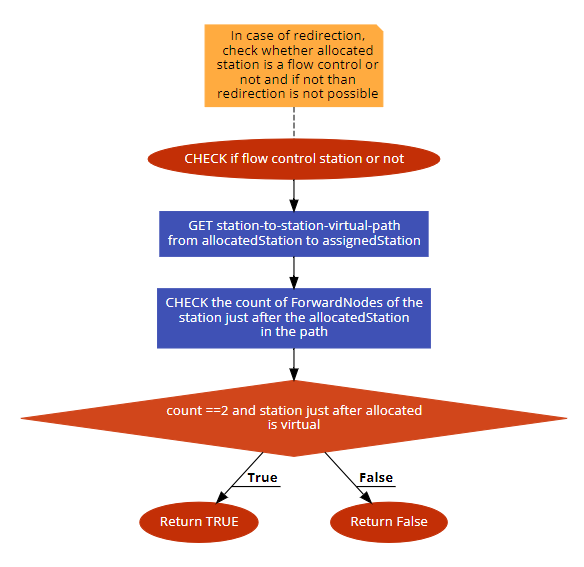